In [1]:
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stock_papertrading import AlpacaPaperTrading
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import numpy as np
import pandas as pd
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import numpy as np
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
df = pd.read_csv("btc_data.csv")

df['date'] = pd.to_datetime(df['Open_time'], unit='ms')
df['tic'] = 'BTC'
df = df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
df = df[['date', 'tic', 'open', 'high', 'low', 'close', 'volume']]

df = df.sort_values("date")



dp = DataProcessor(data_source='binance', time_interval='4h')  # Saatlik veri gibi düşün
processed = dp.clean_data(df)
processed = dp.add_technical_indicator(processed, INDICATORS)
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
train = processed[processed['date'] < '2024-11-01']
test = processed[processed['date'] >= '2024-11-01']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
num_stock_shares = [0] * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct":sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,  # teknik göstergeler eklenmediyse boş bırak
    "action_space": stock_dimension,
    "reward_scaling": 1e-1,
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)


/home/berkant/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/berkant/miniconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Stock Dimension: 1, State Space: 11


In [2]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [3]:

from finrl.agents.stablebaselines3.models import DRLAgent
agent = DRLAgent(env = env_train)

In [4]:
agent = DRLAgent(env = env_train)
model_ppo = agent.get_model("ppo")

trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


/home/berkant/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1044 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 820         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003255749 |
|    clip_fraction        | 0.0126      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.000236   |
|    learning_rate        | 0.00025     |
|    loss                 | 3.47e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00107    |
|    reward               | 1.652       |
|    std        

In [5]:
df_account_value, df_actions = agent.DRL_prediction(model=trained_ppo, environment = e_train_gym)

hit end!


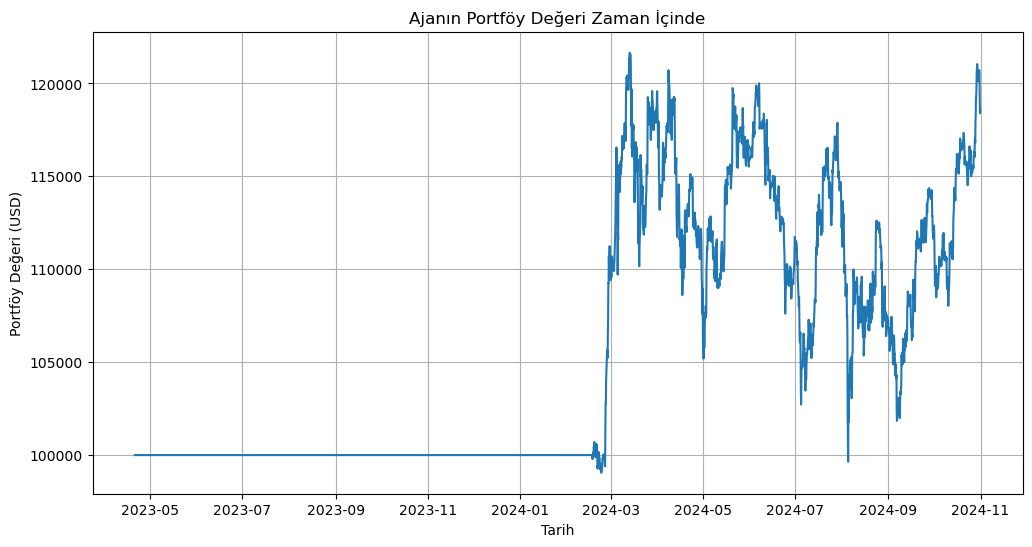

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_account_value['date'], df_account_value['account_value'])
plt.xlabel("Tarih")
plt.ylabel("Portföy Değeri (USD)")
plt.title("Ajanın Portföy Değeri Zaman İçinde")
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)



/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA 

Start date,2023-04-20
End date,2024-10-31
Total months,160
,Backtest
Annual return,6.298%
Cumulative returns,125.827%
Annual volatility,13.841%
Sharpe ratio,0.51
Calmar ratio,0.22
Stability,0.83
Max drawdown,-28.097%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.10,2024-03-13,2024-08-05,NaT,NaN
1,18.00,2023-07-13,2023-09-11,2023-10-23,73
2,15.78,2024-01-11,2024-01-23,2024-02-09,22
3,13.96,2023-04-26,2023-06-15,2023-06-21,41
4,9.33,2024-03-04,2024-03-05,2024-03-08,4


/home/berkant/miniconda3/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.03%,-7.47%,5.29%


Annual return          0.062980
Cumulative returns     1.258268
Annual volatility      0.138408
Sharpe ratio           0.510724
Calmar ratio           0.224153
Stability              0.826289
Max drawdown          -0.280971
Omega ratio            1.104633
Sortino ratio          0.735280
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.090355
Daily value at risk   -0.017157
dtype: float64


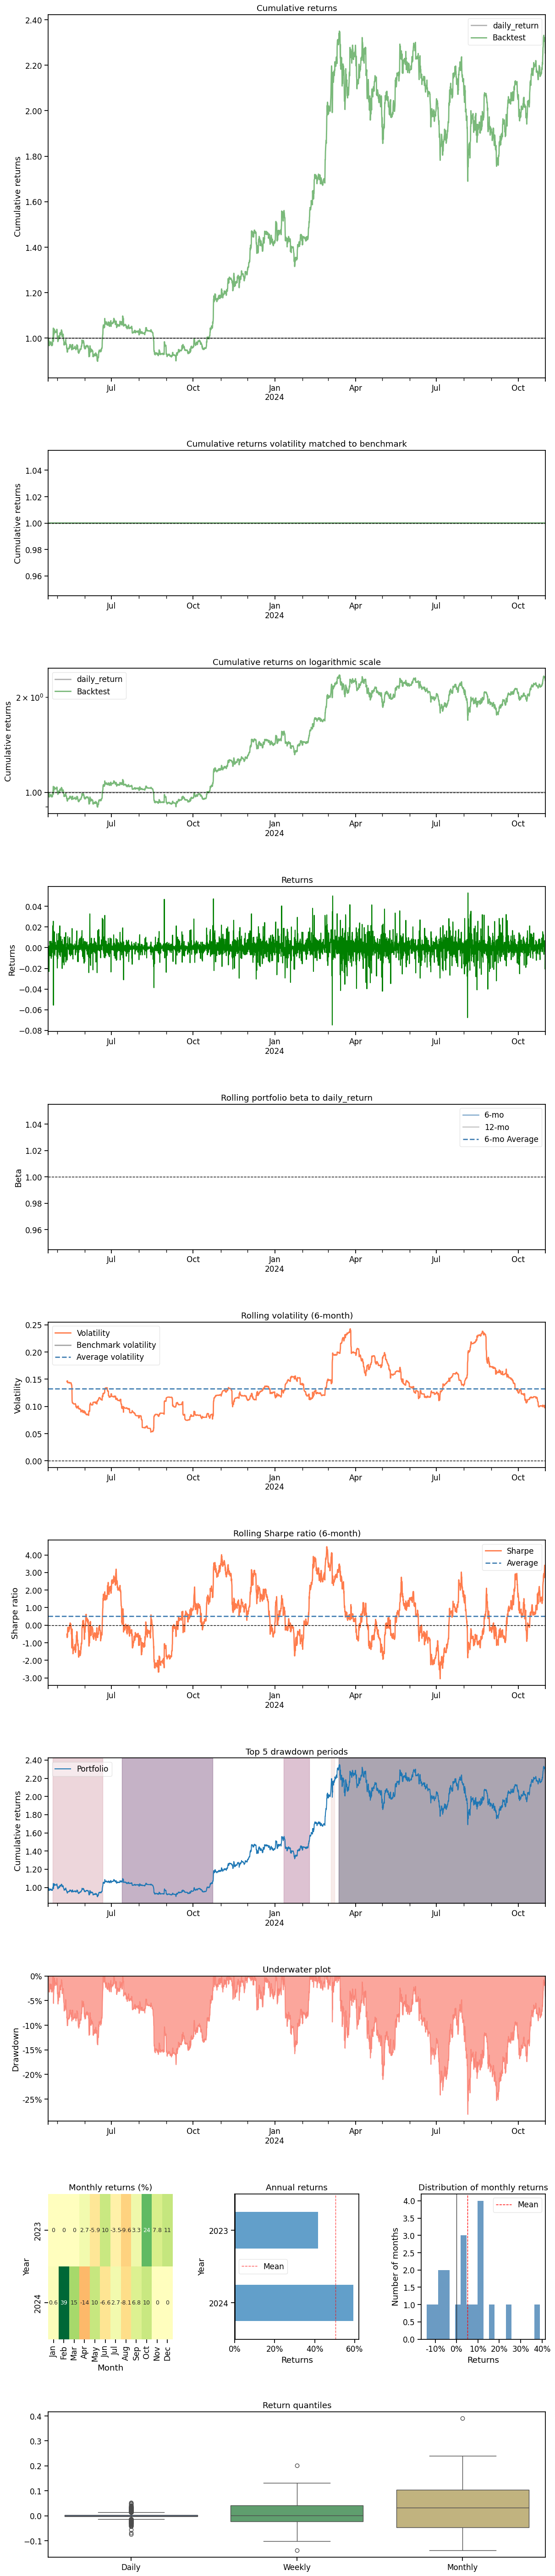

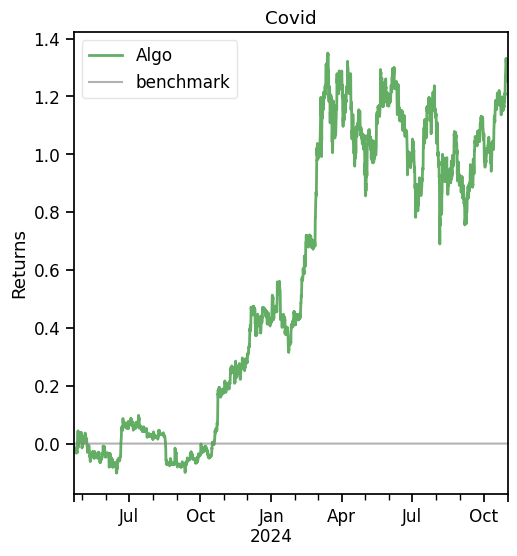

In [7]:
from finrl.plot import backtest_stats, backtest_plot, get_baseline

backtest_plot(df_account_value)
perf_stats = backtest_stats(df_account_value)

In [15]:
print(test.shape)
print(test.head())
print(processed['date'].min(), processed['date'].max())

(1019, 15)
                    date      open      high       low     close       volume  \
3361 2024-11-01 00:00:00  70292.01  70470.00  68830.00  69369.99   6736.08255   
3362 2024-11-01 04:00:00  69369.99  69699.14  69080.00  69273.70   3840.13342   
3363 2024-11-01 08:00:00  69273.70  70228.00  69237.26  70002.01   4258.62726   
3364 2024-11-01 12:00:00  70002.01  71632.95  69044.00  69387.77  12583.25292   
3365 2024-11-01 16:00:00  69387.78  70515.16  68820.14  69268.00   8722.26319   

      tic        macd       boll_ub       boll_lb     rsi_30     cci_30  \
3361  BTC  360.454189  73583.609031  69525.389969  49.854535 -33.723393   
3362  BTC  197.937724  73681.947665  69358.200335  49.411481 -46.862603   
3363  BTC  126.453113  73726.784911  69219.750089  52.700506 -32.898355   
3364  BTC   20.006388  73825.348948  68958.166052  49.871630 -29.352104   
3365  BTC  -73.174339  73894.249954  68670.864046  49.337424 -57.470496   

          dx_30  close_30_sma  close_60_sma  
3361 

In [16]:
test = test.reset_index(drop=True)
e_test_gym = StockTradingEnv(df=test, **env_kwargs)
env_test, test_obs = e_test_gym.get_sb_env()
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_test_gym
)

hit end!


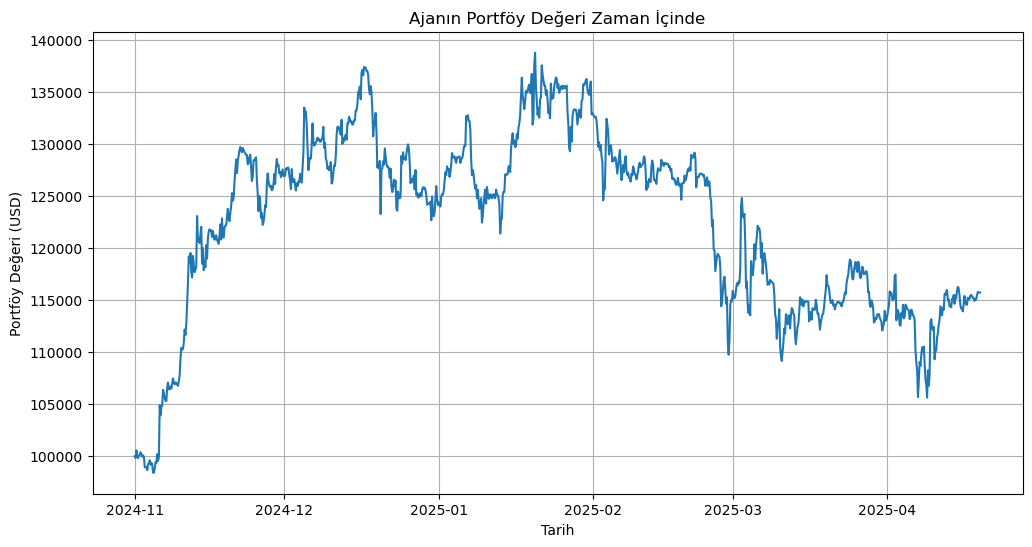

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_account_value['date'], df_account_value['account_value'])
plt.xlabel("Tarih")
plt.ylabel("Portföy Değeri (USD)")
plt.title("Ajanın Portföy Değeri Zaman İçinde")
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)



/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA 

Start date,2024-11-01
End date,2025-04-19
Total months,48
,Backtest
Annual return,3.68%
Cumulative returns,15.733%
Annual volatility,14.334%
Sharpe ratio,0.32
Calmar ratio,0.15
Stability,0.05
Max drawdown,-23.895%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.89,2025-01-20,2025-04-09,NaT,NaN
1,11.65,2024-12-17,2025-01-13,2025-01-20,25
2,5.77,2024-11-22,2024-11-26,2024-12-05,9
3,5.47,2024-12-05,2024-12-10,2024-12-15,7
4,4.24,2024-11-13,2024-11-14,2024-11-19,5


/home/berkant/miniconda3/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.02%,-3.98%,5.16%


Annual return          0.036795
Cumulative returns     0.157329
Annual volatility      0.143339
Sharpe ratio           0.323821
Calmar ratio           0.153988
Stability              0.053558
Max drawdown          -0.238947
Omega ratio            1.063445
Sortino ratio          0.471281
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933434
Daily value at risk   -0.017875
dtype: float64


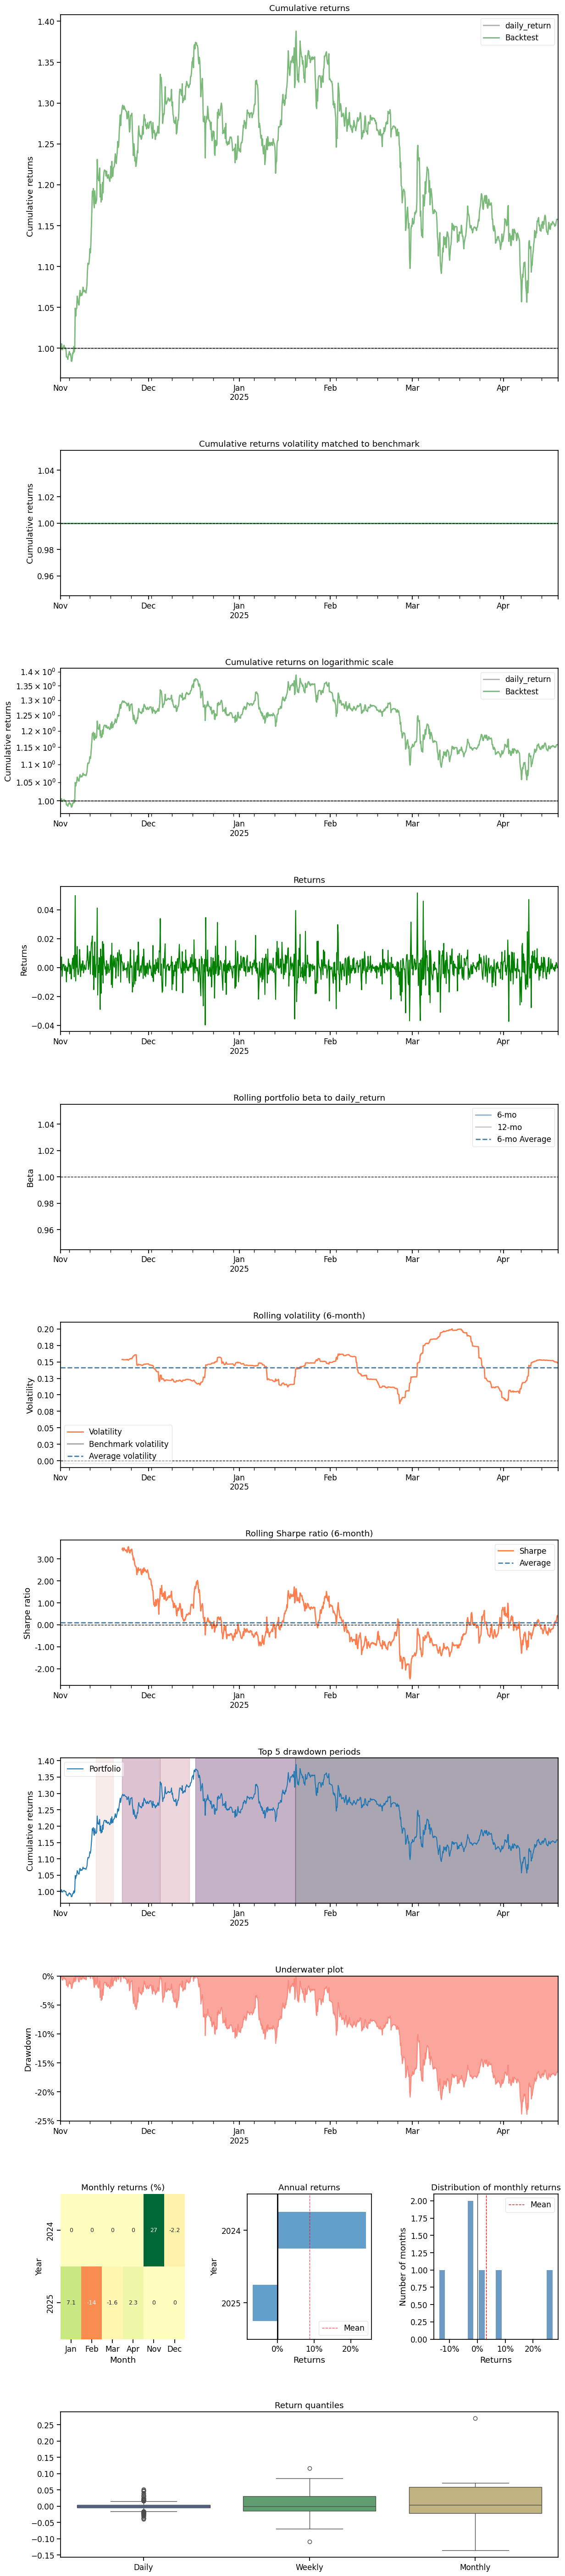

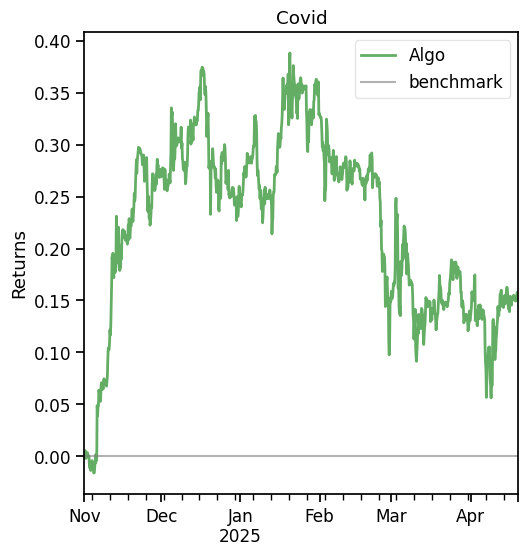

In [18]:
from finrl.plot import backtest_stats, backtest_plot, get_baseline

backtest_plot(df_account_value)
perf_stats = backtest_stats(df_account_value)